In [4]:
# Starter

__author__ = "Philipp Kats"
from datetime import date
__date__ = date.today().strftime('%Y-%m-%d')

%matplotlib inline
import pylab as plt
plt.style.use('fivethirtyeight')

import pandas as pd
import geopandas as gp
import os
import json
import SE
import altair as alt

from tqdm import tqdm, tqdm_notebook
# tqdm().pandas()
#from hyperdash import monitor_cell, Experiment
 

from SE.areas import get_all_areas, get_larger_area
from SE.sql import _get_DF
from SE import definitions
#from SE.sql import queries
idx = pd.IndexSlice

print(__date__)
print(SE.__version__)

2018-09-11
5.8.6


In [5]:
from rasterio import features, Affine, float64
from rasterio.enums import MergeAlg
from xarray import DataArray
import numpy as np

import datashader as ds
from datashader import transfer_functions as tf, reductions as rd
from datashader.colors import Hot, viridis

import colorcet
kbc = colorcet.cm.kbc

In [6]:
def get_transform(cvs):
    '''transform into canvas coordinates'''
    return Affine((cvs.x_range[1] - cvs.x_range[0]) / cvs.plot_width, 0.0,
                   cvs.x_range[0], 0.0, (cvs.y_range[0] - cvs.y_range[1]) / cvs.plot_height, cvs.y_range[1])

In [8]:
from SE.spatial import get_better_boundaries
N = get_better_boundaries(area_type='neighborhood', nyc_crs=True)

In [12]:
cb = pd.read_pickle('../data/correct_geom.pkl')

In [13]:
cb['boundary_name'] = cb['boundary_name'].str.lower()

## Borders

In [108]:
N = get_better_boundaries(area_type='neighborhood', nyc_crs=True)

In [10]:
fh = N[N.name == 'Forest Hills'].iloc[0]

In [16]:
print(fh.geometry.centroid.buffer(15000).envelope)

POLYGON ((1011891.148567103 186966.1753222145, 1041891.148567103 186966.1753222145, 1041891.148567103 216966.1753222145, 1011891.148567103 216966.1753222145, 1011891.148567103 186966.1753222145))


In [17]:
cvs = ds.Canvas(plot_height=1000,
                plot_width=1000,
                x_range=(1011891, 1041891),
                y_range=(186966, 216966))

aform = get_transform(cvs)
aform

Affine(30.0, 0.0, 1011891.0,
       0.0, -30.0, 216966.0)

In [18]:
# borders
border = features.rasterize([(el, 1) for el in N['geometry'].boundary.tolist()] , 
                            out_shape=(cvs.plot_height, cvs.plot_width),
                            merge_alg=MergeAlg.replace, transform=aform, all_touched=True, dtype=float64)

border[border == 0] = np.nan
bd = DataArray(data=pd.np.flipud(border))

## FH overal

In [53]:
FH_all = cb[cb.centroid.within(fh['geometry'])]

In [54]:
FH_all = FH_all[FH_all.area <= 1.5 * fh['geometry'].area]

In [55]:
len(FH_all)

770

In [56]:
F = features.rasterize([(el, 1) for el in FH_all['geometry'].boundary.tolist()],
                       out_shape=(cvs.plot_height, cvs.plot_width),
                       merge_alg=MergeAlg.add, transform=aform, dtype=float64)

df = DataArray(data=pd.np.flipud(F))

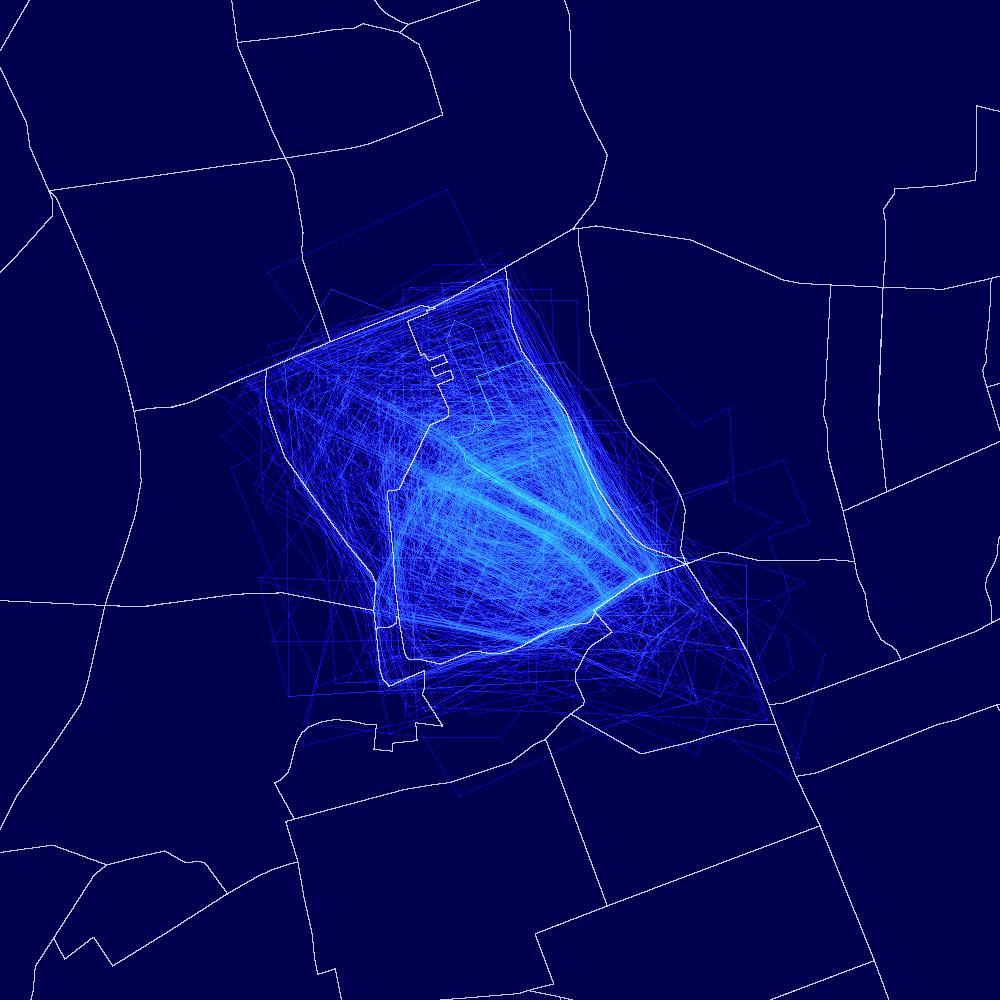

In [57]:
tf.stack(
    tf.shade(df, how='log', cmap=kbc, name='Density'),
    tf.shade(bd, how='eq_hist', cmap=['black','white'], alpha=200)
)

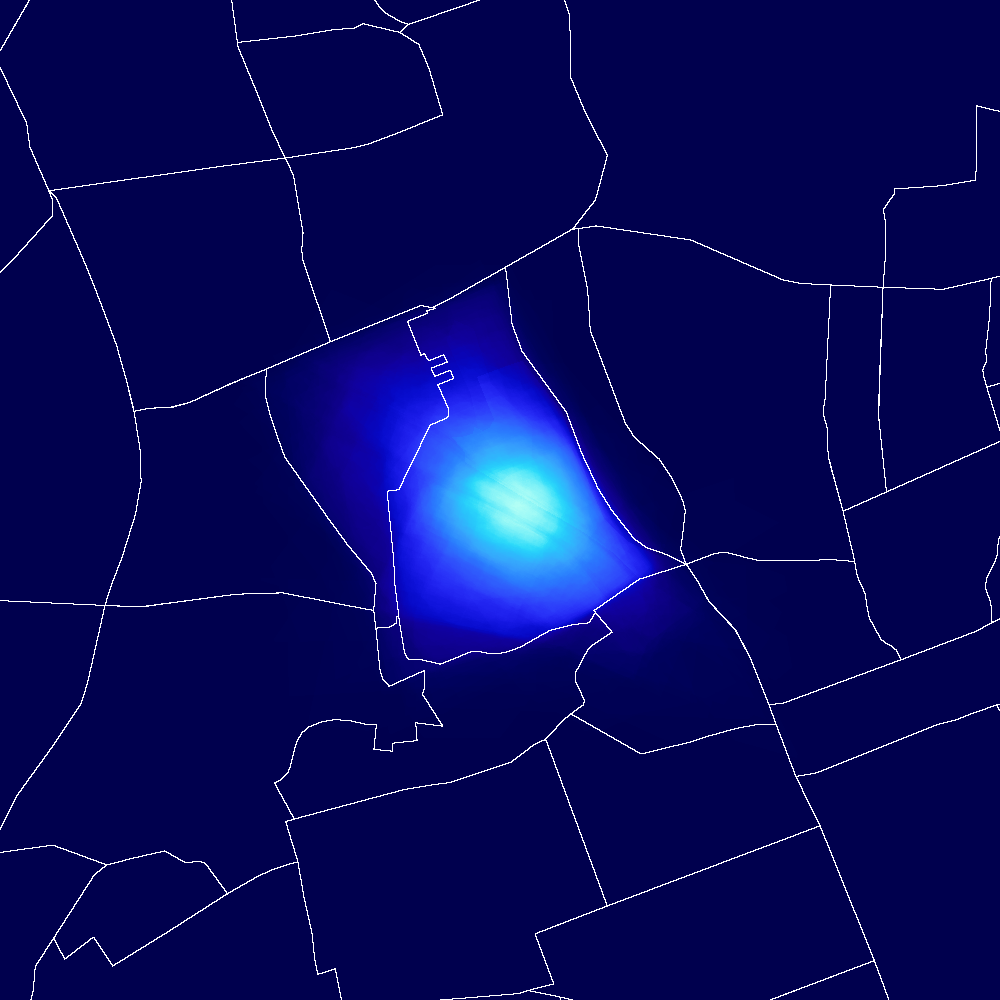

In [58]:
F = features.rasterize([(el, 1) for el in FH_all['geometry'].tolist()],
                       out_shape=(cvs.plot_height, cvs.plot_width),
                       merge_alg=MergeAlg.add, transform=aform, dtype=float64)

data = DataArray(data=pd.np.flipud(F))

tf.stack(tf.shade(data, how='linear', cmap=kbc, name='Density'),
         tf.shade(bd, how='eq_hist', cmap=['black','white']))

## North and South

In [59]:
# south forest hill
sfh = gp.read_file('../data/south_forest_hill.geojson')
from SE.spatial import to_nyc_prj

sfh = to_nyc_prj(sfh)

In [60]:
FH_all['south'] = FH_all.centroid.within(sfh.iloc[0]['geometry'])

In [137]:
Fs = features.rasterize([(el, 1) for el in FH_all[FH_all['south']]['geometry'].tolist()],
                       out_shape=(cvs.plot_height, cvs.plot_width),
                       merge_alg=MergeAlg.add, transform=aform, dtype=float64)

# Fs[Fs ==0] = np.nan

data_s = DataArray(data=pd.np.flipud(Fs))

In [138]:
Fn = features.rasterize([(el, 1) for el in FH_all[~FH_all['south']]['geometry'].tolist()],
                       out_shape=(cvs.plot_height, cvs.plot_width),
                       merge_alg=MergeAlg.add, transform=aform, dtype=float64)

# Fn[Fn==0] = np.nan
data_n = DataArray(data=pd.np.flipud(Fn))

In [150]:
npd = np.dstack((pd.np.flipud(Fs), pd.np.flipud(Fn)))

In [154]:
len(npd[0, 0, :])

2

In [157]:
coords = {'dim_0':range(1000), 'dim_1':range(1000), 'cat':['south', 'north']}

In [159]:
D = DataArray(data=npd, dims=('dim_0', 'dim_1', 'cat'), coords=coords)

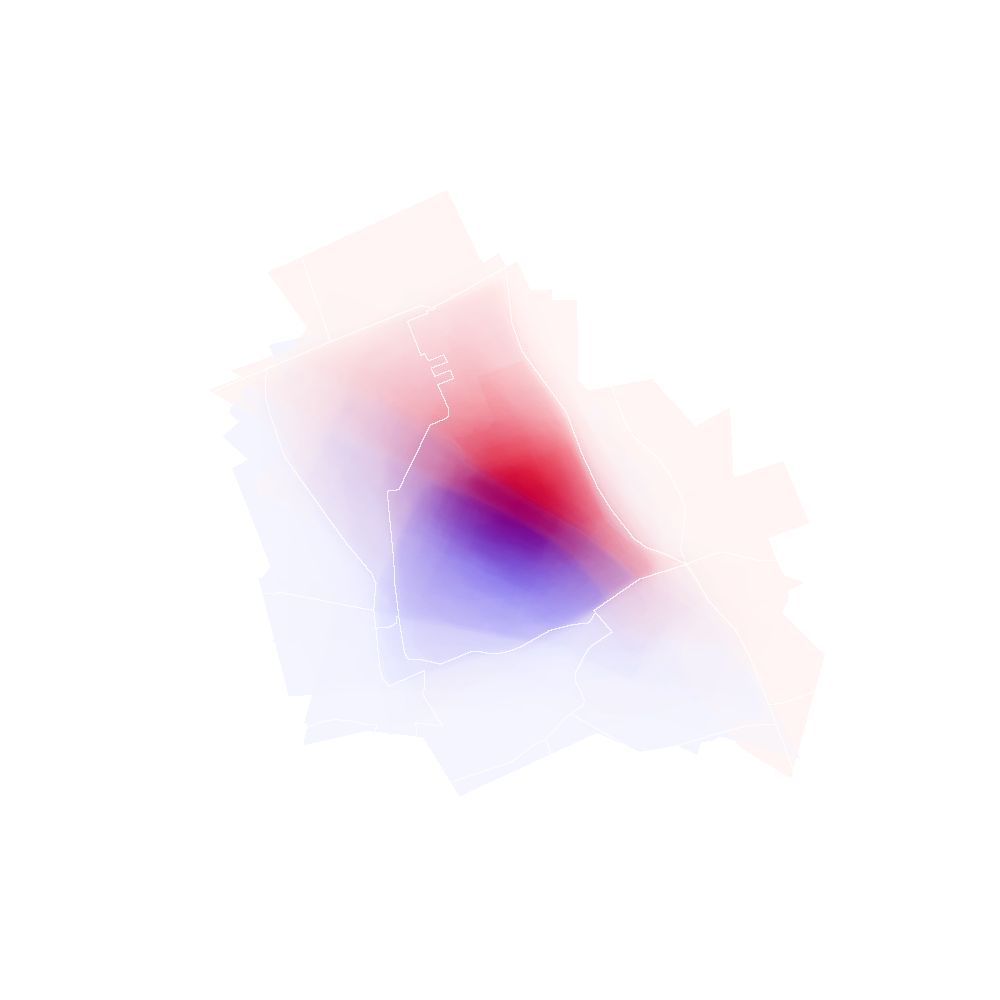

In [163]:
I = tf.stack(
    tf.shade(D, how='linear', color_key=['blue','red'], min_alpha=10),
    tf.shade(bd, how='eq_hist', cmap=['black','white'], alpha=200)
)
I

In [162]:
from datashader.utils import export_image

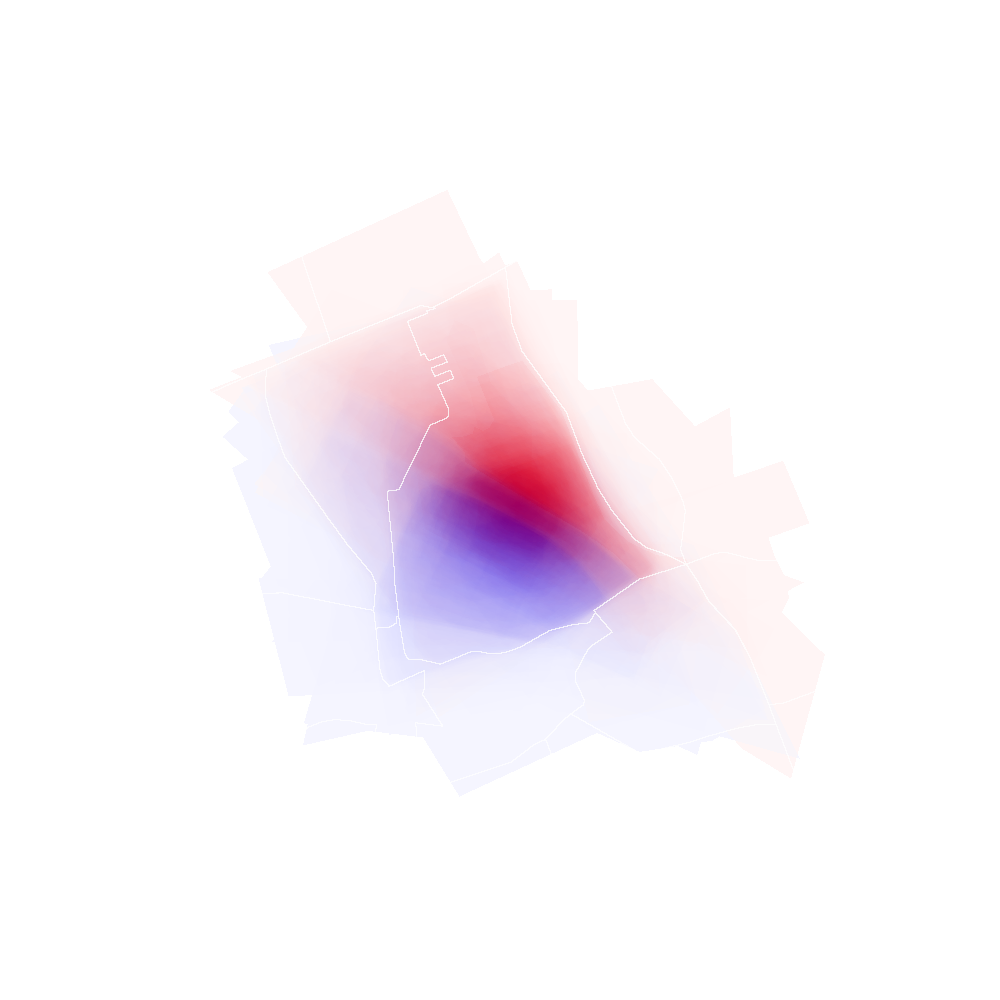

In [166]:
export_image(I, background='white', filename='../img/disagreement/fh_2.png')